## Classification Problem for AQI Bucket

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('cleaned_city_Day.csv')
df.head(10)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,AQI_Bucket,Month,Year
0,Ahmedabad,2015-01-01,58.37,107.96,0.92,18.22,17.15,14.89,0.920,27.64,133.36,149.0,Moderate,1,2015
1,Ahmedabad,2015-01-02,58.37,107.96,0.97,15.69,16.46,14.89,0.970,24.55,34.06,106.0,Moderate,1,2015
2,Ahmedabad,2015-01-03,58.37,107.96,17.40,19.30,29.70,14.89,17.400,29.07,30.70,303.0,Very Poor,1,2015
3,Ahmedabad,2015-01-04,58.37,107.96,1.70,18.48,17.97,14.89,1.700,18.59,36.08,106.0,Moderate,1,2015
4,Ahmedabad,2015-01-05,58.37,107.96,22.10,21.42,37.76,14.89,22.100,39.33,39.31,330.0,Very Poor,1,2015
5,Ahmedabad,2015-01-06,58.37,107.96,45.41,38.48,81.50,14.89,45.410,45.76,46.51,401.0,Severe,1,2015
6,Ahmedabad,2015-01-07,58.37,107.96,112.16,40.62,130.77,14.89,112.160,32.28,33.47,401.0,Severe,1,2015
7,Ahmedabad,2015-01-08,58.37,107.96,80.87,36.74,96.75,14.89,80.870,38.54,31.89,401.0,Severe,1,2015
8,Ahmedabad,2015-01-09,58.37,107.96,29.16,31.00,48.00,14.89,29.160,58.68,25.75,372.0,Very Poor,1,2015
9,Ahmedabad,2015-01-10,58.37,107.96,16.28,7.04,0.00,14.89,16.245,8.29,4.55,289.0,Poor,1,2015


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder # For scaling and encoding

#  extract meaningful features from date
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df = df.drop('Date', axis=1) # Drop original Date column

# Define features (X) and target (y)
x = df.drop(['AQI', 'AQI_Bucket'], axis=1) # Exclude AQI as it's highly correlated with the target
y = df['AQI_Bucket']

# Identify Categorical and Numerical Features 
categorical_features = ['City', 'Month', 'DayOfWeek', 'Year'] # Treat Month/DayOfWeek as categorical for OneHotEncoder
numerical_features = x.select_dtypes(include=np.number).columns.difference(categorical_features).tolist()
# .difference() is to ignore date and month as numerical columns, in case their data type is numerical

print(f"Numerical features to scale: {numerical_features}")
print(f"Categorical features to one-hot encode: {categorical_features}")

Numerical features to scale: ['CO', 'NH3', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5', 'SO2']
Categorical features to one-hot encode: ['City', 'Month', 'DayOfWeek', 'Year']


In [5]:
# Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y is crucial for maintaining class proportions, with 5 categories and Testing Sets

In [6]:
print(f"\nTraining set shape: {x_train.shape}, {y_train.shape}")
print(f"Test set shape: {x_test.shape}, {y_test.shape}")


Training set shape: (19574, 13), (19574,)
Test set shape: (8389, 13), (8389,)


In [7]:
sc_x = StandardScaler()
x_train[numerical_features] = sc_x.fit_transform(x_train[numerical_features])
x_test[numerical_features] = sc_x.transform(x_test[numerical_features])

In [8]:
df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,AQI_Bucket,Month,Year,DayOfWeek
0,Ahmedabad,58.37,107.96,0.92,18.22,17.15,14.89,0.92,27.64,133.36,149.0,Moderate,1,2015,3
1,Ahmedabad,58.37,107.96,0.97,15.69,16.46,14.89,0.97,24.55,34.06,106.0,Moderate,1,2015,4
2,Ahmedabad,58.37,107.96,17.40,19.30,29.70,14.89,17.40,29.07,30.70,303.0,Very Poor,1,2015,5
3,Ahmedabad,58.37,107.96,1.70,18.48,17.97,14.89,1.70,18.59,36.08,106.0,Moderate,1,2015,6
4,Ahmedabad,58.37,107.96,22.10,21.42,37.76,14.89,22.10,39.33,39.31,330.0,Very Poor,1,2015,0


In [9]:
en = OneHotEncoder(sparse_output=False) #creates a column for each category and assigns values 0,1
x_train_encoded = en.fit_transform(x_train[categorical_features])
# Get the new column names generated by OneHotEncoder
encoded_feature_names_train = en.get_feature_names_out(categorical_features)
x_train_encoded_df = pd.DataFrame(x_train_encoded, columns=encoded_feature_names_train, index=x_train.index)

x_test_encoded = en.fit_transform(x_test[categorical_features])
# Get the new column names generated by OneHotEncoder
encoded_feature_names_test = en.get_feature_names_out(categorical_features)
x_test_encoded_df = pd.DataFrame(x_test_encoded, columns=encoded_feature_names_test, index=x_test.index)

In [10]:
# Combine encoded columns with numerical ones
x_train_processed = pd.concat([x_train[numerical_features], x_train_encoded_df], axis=1)
x_test_processed = pd.concat([x_test[numerical_features], x_test_encoded_df], axis=1)

In [11]:
# Fit KNN model after hypertuning parameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_neighbors': np.arange(1, 31),       # number from 1 to 30           
    'metric': ['euclidean', 'manhattan', 'minkowski'],    # Distance metrics
}

random_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=param_grid,
    n_iter=15,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train_processed, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
                   random_state=42, scoring='accuracy', verbose=2)

In [12]:
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best parameters: {'n_neighbors': 11, 'metric': 'minkowski'}
Best cross-validation score: 0.7517627457775116


In [13]:
# Prediction on test data
best_knn = random_search.best_estimator_
y_pred = best_knn.predict(x_test_processed)

In [17]:
# Judging the prediction
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7619501728453928
Classification Report:
               precision    recall  f1-score   support

        Good       0.77      0.61      0.68       453
    Moderate       0.75      0.81      0.78      2833
        Poor       0.62      0.51      0.56       925
Satisfactory       0.81      0.85      0.83      3035
      Severe       0.83      0.70      0.76       416
   Very Poor       0.70      0.67      0.68       727

    accuracy                           0.76      8389
   macro avg       0.75      0.69      0.71      8389
weighted avg       0.76      0.76      0.76      8389



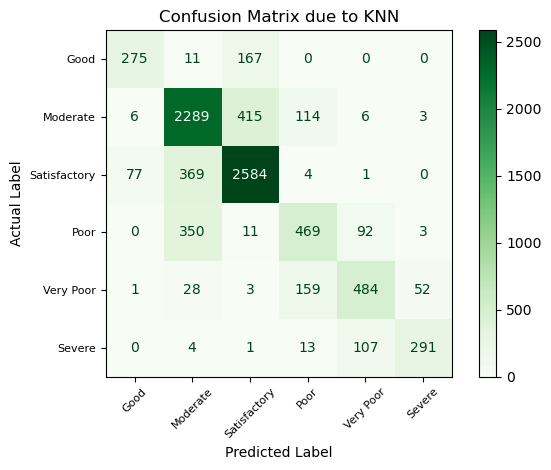

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['Good', 'Moderate', 'Satisfactory', 'Poor', 'Very Poor', 'Severe']

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', values_format='d')  # Show counts
plt.title("Confusion Matrix due to KNN")
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('ConfusionMatrix_KNN.png')
plt.show()


In [38]:
cm

array([[ 275,   11,  167,    0,    0,    0],
       [   6, 2289,  415,  114,    6,    3],
       [  77,  369, 2584,    4,    1,    0],
       [   0,  350,   11,  469,   92,    3],
       [   1,   28,    3,  159,  484,   52],
       [   0,    4,    1,   13,  107,  291]], dtype=int64)

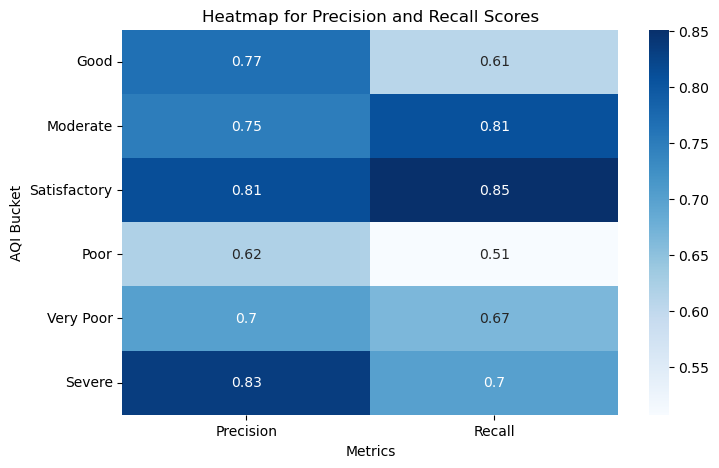

In [46]:
# Get report as dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose() #dictionary to df
report_plot = report_df.drop(columns = ['support', 'f1-score'])
# Proper case for x labels
report_plot.rename(columns = {
    'precision': 'Precision',
    'recall' : 'Recall'
}, inplace=True)

labels = ['Good', 'Moderate', 'Satisfactory', 'Poor', 'Very Poor', 'Severe']
report_plot = report_plot.reindex(labels)
# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(report_plot.iloc[0:6, :], annot=True, cmap="Blues") 
plt.title("Heatmap for Precision and Recall Scores")
plt.xlabel('Metrics')
plt.ylabel('AQI Bucket')
plt.savefig('ClassificationReportHeatmap.png')
plt.show()
